In [57]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import cv2
#import cairocffi as cairo
from re import match
from itertools import product, count, chain
import itertools
from keras.utils import to_categorical

%matplotlib inline
import matplotlib.gridspec as gridspec

from PIL import Image

import random
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences



TensorFlow version: 1.13.1
Keras version: 2.2.4


In [58]:
sess = tf.Session()
K.set_session(sess)

In [59]:
images = os.listdir('./plates/train')
images[0]

'AAA 257.jpg'

In [60]:
#img = cv2.imread('./plates/train/AAA 777.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img = img.astype(np.float32)
#img.shape
#img = cv2.resize(img, (self.img_w, self.img_h))
#img /= 255
#plt.imshow(img)

In [61]:
plate_dirpath = './plates/train'
for filename in os.listdir(plate_dirpath):
            name, ext = os.path.splitext(filename)
            if ext in ['.png', '.jpg']:
                leftpart = name.split(" ")[0]
                rightpart = name.split(" ")[1]
                #print (leftpart)
                #print (rightpart)
                

In [62]:
#type(img)

In [63]:
#img.shape

In [64]:
from collections import Counter
def get_counter(dirpath):
    img_dirpath = dirpath
    
    letters = ''
    lens = []
    for filename in os.listdir(img_dirpath):
            name, ext = os.path.splitext(filename)
            if ext in ['.png', '.jpg']:
                img_filepath = img_dirpath
                #print (img_filepath)
                #json_filepath = join(ann_dirpath, name + '.json')
                #ann = json.load(open(json_filepath, 'r'))
                description = name
            lens.append(len(description))            
            letters += description.split(".")[0]
            
    print('Max plate length in "%s":' % dirpath, max(Counter(lens).keys()))
    return Counter(letters)

c_train = get_counter('./plates/train')
letters_train = set(c_train.keys())

# print(len(letters_train), len(letters_val), len(letters_val | letters_train))
letters = sorted(list(letters_train))
print('Letters:', ' '.join(letters))

Max plate length in "./plates/train": 7
Letters:   0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z


In [65]:


def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

In [66]:
class ImageDataGenerator:
    
    def __init__(self, 
                 dirpath,
                 img_w, img_h, 
                 batch_size, 
                 downsample_factor,
                 max_text_len=7):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        
        img_dirpath = dirpath
        #ann_dirpath = join(dirpath, 'ann')
        self.samples = []
        self.texts = []
        for filename in os.listdir(img_dirpath):
            name, ext = os.path.splitext(filename)
            if ext in ['.png', '.jpg']:
                img_filepath = img_dirpath
                #print (img_filepath)
                #json_filepath = join(ann_dirpath, name + '.json')
                #ann = json.load(open(json_filepath, 'r'))
                description = filename
                #tags = ann['tags']
                #if tag not in tags:
                    #continue
                #if is_valid_str(description):
                self.samples.append([img_filepath, description])
                #print (description)
                self.texts.append(description.split(".")[0])
                print(description.split(".")[0])
                
        
        self.n = len(self.samples)
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        i = 0
        
        while i < len(self.samples):
            #print (img_filepath)
            img = cv2.imread(self.samples[i][0] + '/' + self.samples[i][1])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img /= 255
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            self.imgs[i, :, :] = img            
            self.texts.append(self.samples[i][1].split(".")[0])
            i = i + 1
        
    def get_output_size(self):
        return len(letters) + 1
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            if K.image_data_format() == 'channels_first':
                X_data = np.ones([self.batch_size, 1, self.img_w, self.img_h])
            else:
                X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            source_str = []
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i] = text_to_labels(text)
                source_str.append(text)
                label_length[i] = len(text)
                
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
                #'source_str': source_str
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [67]:
project = ImageDataGenerator('./plates/train', 200, 100, 7, 4)
project.build_data()


AAA 257
AAD 602
AAD 696
AAF 121
AAG 101
AAH 243
AAJ 436
AAK 463
AAM 203
AAM 475
AAN 046
AAO 701
AAP 312
AAQ 294
AAQ 665
AAR 363
AAR 970
AAS 193
AAT 188
AAV 011
AAW 128
AAW 760
AAX 451
ABA 379
ABA 625
ABB 832
ABC 403
ABD 855
ABF 365
ABG 032
ABG 955
ABH 495
ABI 089
ABJ 093
ABM 261
ABP 352
ABP 884
ABR 540
ABT 584
ABW 709
ABW 734
ABY 638
ABY 873
ABZ 310
ABZ 479
ACB 733
ACD 298
ACD 923
ACE 109
ACE 480
ACF 295
ACF 437
ACF 765
ACG 774
ACH 195
ACH 693
ACJ 713
ACK 180
ACL 866
ACM 563
ACM 655
ACN 439
ACQ 014
ACQ 294
ACQ 464
ACR 262
ACS 368
ACT 070
ACT 567
ACT 882
ACV 371
ACY 426
ACY 629
ADB 810
ADD 457
ADE 288
ADF 270
ADH 078
ADI 980
ADL 219
ADM 043
ADM 476
ADM 773
ADN 247
ADO 117
ADP 351
ADQ 578
ADR 426
ADS 134
ADT 961
ADU 675
ADW 083
ADX 861
ADY 169
ADZ 448
AEB 236
AEB 690
AEB 819
AEC 134
AED 401
AED 556
AEE 599
AEJ 905
AEK 240
AEK 371
AEK 728
AEN 190
AEO 851
AEP 272
AEP 431
AER 354
AET 739
AET 825
AET 979
AEV 363
AEV 990
AEW 408
AEX 191
AEY 278
AFA 092
AFA 165
AFA 211
AFA 292
AFB 378
AFB 586


DNX 927
DNY 138
DOA 848
DOD 092
DOG 032
DOG 367
DOH 690
DOI 583
DOK 057
DOK 416
DOL 445
DON 498
DOO 552
DOP 004
DOQ 251
DOQ 776
DOS 776
DOU 689
DOV 163
DOV 383
DOX 359
DOZ 561
DOZ 769
DPA 605
DPA 903
DPB 122
DPB 640
DPC 441
DPC 520
DPD 320
DPE 659
DPE 955
DPI 423
DPK 962
DPL 878
DPL 917
DPL 989
DPN 112
DPN 228
DPP 252
DPQ 787
DPR 249
DPR 855
DPT 726
DPU 951
DPW 082
DPX 501
DPY 652
DQB 875
DQC 609
DQE 062
DQE 205
DQG 227
DQG 360
DQI 942
DQL 840
DQO 880
DQQ 184
DQR 976
DQS 171
DQU 377
DQV 812
DQX 129
DQY 102
DRC 703
DRD 050
DRG 337
DRH 170
DRI 170
DRI 236
DRJ 169
DRJ 422
DRK 365
DRL 150
DRL 680
DRN 311
DRP 553
DRQ 749
DRR 373
DRT 024
DRT 038
DRT 052
DRT 058
DRT 979
DRU 093
DRU 402
DRV 964
DRY 839
DRZ 825
DSA 892
DSB 435
DSB 673
DSC 461
DSC 695
DSD 559
DSF 522
DSG 266
DSH 062
DSI 413
DSJ 600
DSK 753
DSL 263
DSM 146
DSM 186
DSQ 086
DSQ 278
DSR 599
DST 060
DST 330
DSU 175
DSV 066
DSW 139
DSW 150
DSW 185
DSW 341
DSW 858
DSY 235
DSY 330
DSY 597
DSY 639
DSZ 147
DTA 773
DTE 724
DTF 414
DTG 089


GYF 501
GYG 451
GYI 349
GYL 056
GYL 847
GYL 934
GYO 900
GYP 321
GYU 511
GYX 306
GYX 366
GYX 875
GYY 339
GYZ 173
GZA 089
GZB 092
GZB 410
GZF 215
GZF 331
GZG 529
GZH 274
GZI 869
GZJ 103
GZJ 535
GZJ 640
GZN 484
GZN 819
GZO 957
GZP 899
GZQ 635
GZS 143
GZV 996
GZW 033
GZW 682
GZY 996
GZZ 039
GZZ 355
HAA 388
HAA 556
HAB 468
HAD 717
HAG 438
HAM 008
HAP 883
HAQ 457
HAQ 559
HAQ 572
HAR 143
HAS 743
HAT 015
HAT 196
HAV 099
HAX 351
HAY 147
HBA 138
HBD 108
HBF 044
HBF 195
HBH 074
HBI 328
HBJ 349
HBJ 376
HBK 607
HBP 640
HBR 041
HBR 846
HBS 061
HBV 133
HBV 771
HBV 997
HBW 014
HBW 173
HBW 805
HBX 147
HBX 246
HBX 561
HBY 143
HBY 695
HCA 150
HCB 122
HCB 760
HCE 370
HCF 321
HCG 728
HCI 665
HCJ 039
HCJ 312
HCJ 641
HCK 114
HCK 298
HCK 464
HCL 280
HCM 626
HCR 745
HCS 928
HCT 517
HCU 269
HCV 824
HCW 724
HCX 044
HCY 469
HCY 816
HCZ 764
HDA 329
HDA 356
HDC 213
HDG 346
HDI 567
HDI 714
HDJ 378
HDL 142
HDP 830
HDQ 220
HDT 788
HDU 210
HDU 875
HDV 081
HDV 274
HDV 541
HDV 838
HDX 209
HDX 411
HDX 832
HDY 042
HDZ 502


KHM 584
KHO 751
KHR 023
KHS 738
KHU 148
KHV 628
KHY 139
KHY 304
KHY 749
KHY 766
KIA 529
KIA 533
KIA 567
KIB 990
KID 181
KID 256
KIE 696
KIH 239
KIN 462
KIQ 570
KIQ 910
KIS 384
KIS 520
KIU 107
KIY 251
KIZ 345
KJA 985
KJB 056
KJC 654
KJD 781
KJE 031
KJE 240
KJE 317
KJE 793
KJF 434
KJG 006
KJH 112
KJH 676
KJI 187
KJI 768
KJM 359
KJO 356
KJO 766
KJP 896
KJS 975
KJT 213
KJU 880
KJX 512
KJY 293
KKA 238
KKC 563
KKE 884
KKF 545
KKH 719
KKI 118
KKK 202
KKL 480
KKM 986
KKO 221
KKO 443
KKO 833
KKP 178
KKS 014
KKS 343
KKS 865
KKS 880
KKZ 582
KLB 534
KLB 541
KLE 099
KLE 321
KLE 403
KLE 579
KLG 245
KLI 956
KLJ 118
KLJ 924
KLK 156
KLM 076
KLM 682
KLM 879
KLN 736
KLO 130
KLO 431
KLP 241
KLP 426
KLP 681
KLP 998
KLQ 000
KLQ 522
KLQ 656
KLR 958
KLR 993
KLS 797
KLU 635
KLW 064
KLX 286
KLX 594
KLY 587
KLZ 392
KMA 104
KMA 479
KMC 511
KMD 484
KME 081
KME 623
KMG 701
KMH 136
KMI 424
KMI 748
KMI 888
KMJ 253
KMJ 909
KML 694
KMO 762
KMS 438
KMT 288
KMT 426
KMY 548
KMZ 059
KNB 181
KNF 293
KNF 586
KNG 785
KNH 929


NTZ 420
NTZ 958
NUA 216
NUB 941
NUD 269
NUD 454
NUE 047
NUG 110
NUI 818
NUI 977
NUI 983
NUJ 368
NUJ 901
NUL 549
NUO 912
NUR 628
NUR 891
NUR 895
NUR 978
NUT 208
NUV 793
NUX 813
NUX 818
NVB 571
NVC 692
NVE 466
NVF 844
NVH 151
NVI 005
NVI 172
NVI 231
NVI 579
NVJ 256
NVJ 931
NVK 353
NVL 125
NVL 523
NVL 687
NVM 118
NVM 705
NVN 093
NVN 566
NVO 606
NVO 668
NVO 753
NVQ 495
NVS 873
NVS 916
NVU 935
NVU 959
NVU 993
NVV 336
NVV 422
NVV 875
NVW 942
NVX 025
NVX 959
NVY 186
NVY 828
NWA 358
NWB 066
NWB 357
NWC 021
NWC 703
NWC 954
NWD 998
NWE 136
NWE 692
NWF 614
NWG 248
NWI 720
NWJ 304
NWK 484
NWL 192
NWO 901
NWP 650
NWQ 169
NWS 419
NWS 466
NWT 942
NWU 222
NWU 640
NWV 137
NWW 444
NWW 638
NWW 979
NWX 024
NWX 787
NWY 717
NXB 298
NXD 679
NXF 178
NXF 790
NXG 668
NXH 822
NXJ 842
NXN 368
NXP 498
NXQ 043
NXQ 044
NXQ 480
NXR 080
NXS 254
NXT 773
NXU 849
NXW 564
NXX 177
NXX 327
NYB 559
NYC 036
NYC 533
NYC 879
NYD 293
NYD 525
NYD 668
NYF 058
NYG 666
NYH 192
NYJ 878
NYM 011
NYM 961
NYN 272
NYO 416
NYP 688
NYQ 623


QZW 243
RAA 131
RAE 389
RAI 400
RAK 817
RAL 659
RAM 482
RAN 899
RAQ 019
RAQ 744
RAV 583
RAW 440
RAW 675
RAX 822
RBA 318
RBF 767
RBF 959
RBF 986
RBG 092
RBG 300
RBG 465
RBI 905
RBJ 889
RBM 459
RBN 772
RBO 265
RBQ 337
RBQ 546
RBU 993
RBW 055
RBY 234
RCB 500
RCC 096
RCD 675
RCE 662
RCG 100
RCG 257
RCG 960
RCI 612
RCK 240
RCK 930
RCM 126
RCQ 521
RCS 140
RCT 007
RCT 250
RCW 510
RCW 565
RCX 625
RDA 229
RDB 151
RDB 690
RDD 484
RDE 667
RDH 857
RDI 359
RDI 483
RDJ 482
RDK 895
RDL 497
RDL 773
RDN 563
RDR 185
RDR 271
RDT 622
RDV 227
RDV 852
RDW 721
RDX 026
RDX 539
RDY 188
RDZ 128
RDZ 841
REB 530
REC 282
REC 928
RED 706
REE 718
REG 536
REG 721
REH 092
REI 415
REI 725
REI 952
REJ 395
REK 194
REN 721
REO 101
REO 833
RER 695
RES 341
RET 691
REU 831
REV 423
REV 445
REV 728
REW 500
REW 627
REX 260
REX 923
REY 907
REZ 315
REZ 683
RFA 931
RFD 537
RFE 280
RFE 728
RFG 313
RFH 176
RFI 335
RFI 805
RFK 271
RFL 374
RFL 971
RFM 260
RFM 732
RFM 807
RFO 865
RFP 407
RFQ 227
RFV 028
RFW 426
RFW 523
RFY 103
RFY 397


VBI 977
VBL 111
VBL 294
VBM 984
VBN 306
VBO 606
VBP 502
VBQ 616
VBR 466
VBR 859
VBT 346
VBU 866
VBW 061
VBW 080
VBW 205
VBW 844
VBX 554
VBX 993
VCB 798
VCC 062
VCC 439
VCD 243
VCD 274
VCD 431
VCE 532
VCE 746
VCF 198
VCF 718
VCG 051
VCG 124
VCH 040
VCI 174
VCJ 491
VCM 396
VCN 968
VCN 981
VCP 883
VCQ 190
VCQ 226
VCQ 725
VCS 113
VCU 119
VCU 782
VCV 027
VCV 429
VCV 699
VCV 758
VCV 946
VCW 622
VCX 085
VCZ 790
VDC 329
VDE 862
VDE 938
VDF 100
VDF 595
VDG 919
VDG 982
VDH 411
VDI 954
VDK 818
VDN 608
VDO 207
VDO 386
VDR 462
VDU 462
VDV 272
VDX 489
VDZ 612
VEA 268
VEA 658
VEC 415
VED 057
VED 296
VEH 412
VEH 819
VEI 602
VEI 784
VEJ 346
VEK 680
VEL 642
VEO 456
VEP 822
VEQ 250
VES 100
VEW 670
VEX 037
VFA 527
VFA 708
VFC 850
VFC 942
VFC 966
VFE 325
VFF 367
VFF 741
VFF 978
VFG 052
VFH 611
VFH 989
VFK 571
VFK 739
VFL 690
VFL 979
VFM 206
VFM 440
VFM 524
VFO 823
VFS 240
VFU 821
VFY 506
VGA 026
VGB 298
VGB 419
VGC 803
VGD 003
VGD 742
VGD 939
VGE 302
VGF 146
VGF 380
VGF 573
VGG 842
VGL 536
VGM 715
VGQ 167


YSC 464
YSE 320
YSE 447
YSF 965
YSH 827
YSK 631
YSN 031
YSQ 100
YSQ 573
YSS 013
YSS 851
YST 399
YSU 066
YSU 365
YSW 056
YSW 568
YSY 077
YSZ 141
YTA 146
YTB 636
YTB 682
YTE 374
YTE 969
YTG 026
YTI 556
YTI 959
YTK 658
YTK 680
YTL 902
YTN 605
YTN 725
YTO 706
YTP 086
YTQ 496
YTT 708
YTU 196
YTU 781
YTV 813
YTW 110
YTW 459
YTX 306
YTY 731
YTZ 008
YTZ 762
YUC 283
YUC 662
YUC 918
YUF 087
YUF 885
YUH 339
YUH 811
YUH 813
YUH 827
YUJ 444
YUL 328
YUM 849
YUN 231
YUO 781
YUP 656
YUQ 093
YUR 259
YUR 519
YUR 794
YUU 686
YUV 156
YUX 180
YUX 871
YVA 261
YVA 576
YVB 357
YVD 372
YVD 571
YVH 316
YVJ 106
YVJ 657
YVJ 975
YVK 268
YVK 417
YVK 516
YVK 965
YVK 979
YVL 467
YVL 944
YVM 366
YVN 582
YVN 788
YVQ 071
YVQ 818
YVV 349
YVW 793
YVY 235
YWA 451
YWA 600
YWA 912
YWB 659
YWB 830
YWD 748
YWF 477
YWG 849
YWI 690
YWI 938
YWL 249
YWL 273
YWO 025
YWO 252
YWQ 265
YWR 512
YWR 791
YWR 809
YWR 976
YWV 656
YWW 117
YWW 169
YWW 666
YXB 622
YXC 219
YXF 302
YXG 402
YXH 752
YXI 601
YXM 619
YXO 226
YXO 465
YXO 474
YXO 733


Text generator output (data which will be fed into the neural network):
1) the_input (image)


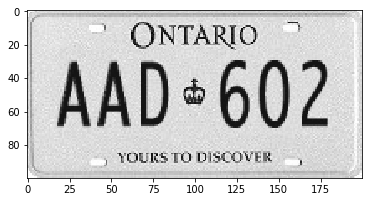

2) the_labels (plate number): AAD 602 is encoded as [11, 11, 14, 0, 7, 1, 3]
3) input_length (width of image that is fed to the loss function): 48 == 200 / 4 - 2
4) label_length (length of plate number): 7


In [68]:
for inp, out in project.next_batch():
    print('Text generator output (data which will be fed into the neural network):')
    print('1) the_input (image)')
    
    if K.image_data_format() == 'channels_first':
        img = inp['the_input'][0, 0, :, :]
    else:
        img = inp['the_input'][0, :, :, 0]
    
    plt.imshow(img.T, cmap='gray')
    plt.show()
    print('2) the_labels (plate number): %s is encoded as %s' % 
          (labels_to_text(inp['the_labels'][0]), list(map(int, inp['the_labels'][0]))))
    print('3) input_length (width of image that is fed to the loss function): %d == %d / 4 - 2' % 
          (inp['input_length'][0], project.img_w))
    print('4) label_length (length of plate number): %d' % inp['label_length'][0])
    #print(inp['the_labels'][0])
    
    
    input_shape = (200, 100, 1)
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    #print(type(input_data))
    #print(project.n)
    
    break

In [69]:
from keras.callbacks import ModelCheckpoint

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def train(img_w, load=False):
    # Input Parameters
    img_h = 100

    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 512

    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
        
    batch_size = 32
    downsample_factor = pool_size ** 2
    project_train = ImageDataGenerator('./plates/train', img_w, img_h, batch_size, downsample_factor)
    project_train.build_data()
    project_val = ImageDataGenerator('./plates/validation', img_w, img_h, batch_size, downsample_factor)
    project_val.build_data()
    
    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)


    # Two layers of bidirecitonal GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(project_train.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[project_train.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

    if load:
        model = load_model('./tmp_model.h5', compile=False)
    else:
        model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    
    if not load:
        # captures output of softmax so we can decode the output during visualization
        test_func = K.function([input_data], [y_pred])
        
        checkpointer = ModelCheckpoint(filepath='./saved_models/weights.best.from.scratch.hdf5')

        model.fit_generator(generator=project_train.next_batch(), 
                            steps_per_epoch=project_train.n,
                            epochs=2, 
                            validation_data=project_val.next_batch(), 
                            validation_steps=project_val.n)

    return model

In [70]:
model = train(200, load=False)

AAA 257
AAD 602
AAD 696
AAF 121
AAG 101
AAH 243
AAJ 436
AAK 463
AAM 203
AAM 475
AAN 046
AAO 701
AAP 312
AAQ 294
AAQ 665
AAR 363
AAR 970
AAS 193
AAT 188
AAV 011
AAW 128
AAW 760
AAX 451
ABA 379
ABA 625
ABB 832
ABC 403
ABD 855
ABF 365
ABG 032
ABG 955
ABH 495
ABI 089
ABJ 093
ABM 261
ABP 352
ABP 884
ABR 540
ABT 584
ABW 709
ABW 734
ABY 638
ABY 873
ABZ 310
ABZ 479
ACB 733
ACD 298
ACD 923
ACE 109
ACE 480
ACF 295
ACF 437
ACF 765
ACG 774
ACH 195
ACH 693
ACJ 713
ACK 180
ACL 866
ACM 563
ACM 655
ACN 439
ACQ 014
ACQ 294
ACQ 464
ACR 262
ACS 368
ACT 070
ACT 567
ACT 882
ACV 371
ACY 426
ACY 629
ADB 810
ADD 457
ADE 288
ADF 270
ADH 078
ADI 980
ADL 219
ADM 043
ADM 476
ADM 773
ADN 247
ADO 117
ADP 351
ADQ 578
ADR 426
ADS 134
ADT 961
ADU 675
ADW 083
ADX 861
ADY 169
ADZ 448
AEB 236
AEB 690
AEB 819
AEC 134
AED 401
AED 556
AEE 599
AEJ 905
AEK 240
AEK 371
AEK 728
AEN 190
AEO 851
AEP 272
AEP 431
AER 354
AET 739
AET 825
AET 979
AEV 363
AEV 990
AEW 408
AEX 191
AEY 278
AFA 092
AFA 165
AFA 211
AFA 292
AFB 378
AFB 586


DCJ 289
DCK 816
DCL 149
DCM 184
DCM 458
DCO 635
DCO 869
DCO 949
DCQ 053
DCQ 198
DCR 191
DCS 339
DCS 915
DCU 414
DCV 809
DCX 788
DCZ 407
DDB 352
DDD 180
DDG 443
DDG 716
DDH 026
DDH 146
DDH 914
DDI 291
DDI 836
DDJ 269
DDK 371
DDL 759
DDM 981
DDP 188
DDP 199
DDP 457
DDU 198
DDU 308
DDX 204
DDY 100
DDZ 065
DDZ 959
DEA 700
DEB 315
DEB 387
DEC 648
DED 137
DED 334
DED 613
DED 895
DEE 595
DEG 922
DEH 075
DEJ 281
DEL 264
DEL 574
DEN 987
DEO 584
DEP 156
DEP 182
DEQ 932
DES 057
DES 235
DEX 002
DEX 225
DEZ 084
DEZ 945
DFC 839
DFD 533
DFE 675
DFH 310
DFI 199
DFI 393
DFK 268
DFL 006
DFQ 351
DFR 721
DFR 755
DFT 054
DFV 225
DFW 456
DFW 461
DFW 882
DFY 175
DFZ 305
DGB 392
DGB 751
DGC 430
DGE 900
DGG 143
DGG 888
DGH 192
DGI 694
DGI 729
DGJ 116
DGJ 331
DGJ 592
DGL 111
DGL 148
DGL 724
DGN 086
DGN 237
DGR 043
DGR 824
DGX 336
DGY 007
DGZ 611
DGZ 824
DHA 292
DHA 780
DHA 858
DHA 995
DHC 099
DHC 838
DHD 065
DHE 553
DHF 001
DHF 104
DHG 030
DHG 395
DHH 979
DHI 397
DHJ 866
DHK 903
DHL 075
DHL 871
DHM 162
DHP 319


FYY 886
FYZ 233
FYZ 663
FYZ 978
FZA 776
FZA 963
FZB 153
FZB 292
FZB 433
FZD 710
FZE 636
FZF 919
FZJ 382
FZJ 645
FZP 521
FZP 854
FZS 125
FZS 928
FZT 109
FZX 672
FZY 491
FZZ 063
FZZ 516
FZZ 769
FZZ 910
GAA 985
GAD 119
GAE 639
GAF 342
GAG 355
GAK 212
GAM 482
GAN 818
GAP 746
GAQ 163
GAQ 341
GAQ 551
GAS 229
GAS 371
GAV 092
GAW 204
GAW 440
GAX 137
GAX 728
GAY 818
GAZ 028
GBA 620
GBB 291
GBB 861
GBD 371
GBD 433
GBF 038
GBK 066
GBK 796
GBL 177
GBN 333
GBN 545
GBO 077
GBO 213
GBQ 617
GBR 166
GBS 750
GBT 020
GBT 871
GBU 555
GBV 476
GBY 731
GCA 594
GCA 652
GCB 432
GCB 901
GCE 426
GCE 455
GCE 627
GCG 134
GCJ 732
GCL 227
GCL 725
GCQ 515
GCT 944
GCU 155
GCU 823
GCV 899
GCW 306
GCX 117
GDG 165
GDH 057
GDI 594
GDM 169
GDN 341
GDN 861
GDO 320
GDP 047
GDP 562
GDR 541
GDS 774
GDU 917
GDV 013
GDV 893
GDX 444
GDY 413
GDY 416
GEB 123
GEC 969
GED 347
GED 372
GEG 946
GEM 954
GEN 226
GEN 903
GEP 319
GEP 420
GEP 681
GEQ 000
GEQ 189
GER 205
GER 607
GER 755
GES 681
GET 124
GET 181
GET 933
GEW 164
GEW 472
GEY 268


JAF 888
JAK 131
JAK 539
JAL 400
JAM 834
JAN 357
JAN 777
JAO 088
JAQ 159
JAT 200
JAU 438
JAU 681
JAV 094
JAW 558
JAW 994
JAX 077
JAX 296
JAY 449
JAY 665
JBA 387
JBC 141
JBD 465
JBE 569
JBI 772
JBJ 264
JBK 965
JBM 332
JBO 560
JBP 698
JBS 080
JBT 632
JBU 439
JBV 110
JBW 782
JCA 644
JCC 056
JCC 195
JCC 727
JCD 716
JCD 787
JCE 656
JCF 028
JCF 837
JCH 017
JCH 449
JCH 462
JCI 389
JCI 636
JCK 009
JCK 891
JCL 475
JCN 211
JCO 780
JCO 921
JCQ 468
JCS 464
JCT 229
JCW 787
JCW 896
JCX 338
JCY 755
JCZ 370
JCZ 694
JDA 308
JDB 087
JDB 739
JDC 842
JDD 347
JDE 153
JDE 790
JDF 645
JDG 053
JDG 462
JDG 768
JDI 499
JDL 089
JDL 399
JDN 070
JDN 359
JDO 165
JDO 359
JDQ 436
JDT 254
JDT 525
JDW 075
JDW 563
JDZ 959
JEB 411
JED 200
JEE 581
JEE 883
JEE 900
JEH 001
JEH 104
JEI 789
JEI 858
JEK 361
JEL 229
JEL 312
JEL 446
JEN 247
JEN 492
JEO 255
JEP 022
JEQ 919
JEU 424
JEW 177
JEX 144
JEX 188
JEX 458
JEX 999
JFA 618
JFA 718
JFC 583
JFD 324
JFE 117
JFE 370
JFF 607
JFF 808
JFF 970
JFH 373
JFI 514
JFJ 050
JFK 259
JFL 107


MKA 314
MKA 824
MKA 912
MKB 060
MKB 355
MKB 980
MKC 274
MKD 913
MKE 992
MKF 168
MKH 531
MKI 306
MKJ 185
MKK 405
MKL 414
MKP 273
MKQ 485
MKQ 674
MKQ 945
MKS 065
MKS 083
MKS 317
MKU 000
MKU 576
MKV 040
MLA 870
MLB 837
MLE 276
MLG 385
MLH 567
MLK 297
MLL 285
MLL 522
MLM 015
MLM 979
MLQ 887
MLS 561
MLS 761
MLU 615
MLV 343
MLZ 890
MMA 171
MMC 462
MME 523
MMF 310
MMF 997
MMH 698
MMH 737
MMH 860
MMK 168
MML 500
MMN 594
MMO 513
MMP 377
MMQ 123
MMR 069
MMR 445
MMR 971
MMT 096
MMT 637
MMU 935
MMV 661
MMW 445
MNA 621
MNC 300
MND 608
MNE 128
MNE 158
MNE 191
MNE 203
MNE 324
MNE 634
MNE 649
MNF 882
MNH 012
MNH 353
MNH 596
MNH 879
MNI 155
MNK 225
MNL 984
MNR 965
MNS 007
MNT 620
MNT 879
MNU 886
MNV 547
MNW 513
MOA 239
MOC 011
MOC 107
MOC 270
MOC 710
MOD 377
MOE 221
MOF 656
MOH 346
MOI 401
MOJ 238
MOJ 251
MOK 123
MOM 852
MON 748
MOO 394
MOP 585
MOQ 576
MOQ 889
MOR 132
MOR 282
MOT 398
MOT 984
MOU 762
MOZ 162
MPB 527
MPB 726
MPB 870
MPD 665
MPE 125
MPE 160
MPF 838
MPF 856
MPG 676
MPH 113
MPI 412
MPI 652


PUP 908
PUR 138
PUT 381
PUU 450
PUU 503
PUU 891
PUV 298
PUV 450
PUY 424
PUY 925
PUZ 175
PVB 416
PVB 680
PVC 750
PVD 568
PVD 826
PVF 909
PVG 657
PVK 221
PVK 430
PVK 952
PVL 629
PVL 688
PVN 185
PVN 879
PVP 367
PVQ 551
PVR 150
PVS 740
PVS 779
PVS 935
PVT 192
PVV 358
PVV 923
PVW 863
PVX 478
PVX 903
PVY 242
PVZ 168
PVZ 602
PWE 057
PWF 132
PWG 952
PWH 314
PWI 117
PWI 390
PWI 416
PWI 511
PWI 796
PWI 902
PWL 808
PWM 361
PWM 470
PWM 665
PWO 821
PWO 859
PWP 123
PWP 623
PWQ 969
PWR 126
PWR 164
PWT 472
PWT 581
PWT 706
PWU 055
PWU 950
PWV 727
PWW 831
PWX 482
PWY 518
PWZ 809
PXD 036
PXD 806
PXF 002
PXF 118
PXG 047
PXG 125
PXG 830
PXG 940
PXH 138
PXH 210
PXH 529
PXI 285
PXI 880
PXL 125
PXM 543
PXN 440
PXN 908
PXQ 219
PXR 753
PXS 123
PXT 435
PXU 195
PXU 361
PXU 518
PXY 263
PXY 333
PXY 954
PXZ 764
PXZ 961
PYB 951
PYC 880
PYE 394
PYE 610
PYE 744
PYE 941
PYF 535
PYG 025
PYH 338
PYJ 436
PYJ 519
PYJ 688
PYJ 873
PYM 902
PYN 875
PYN 963
PYO 066
PYO 641
PYP 599
PYP 871
PYU 288
PYU 488
PYZ 485
PZA 731
PZE 062


TCO 029
TCO 221
TCO 517
TCO 988
TCP 839
TCQ 384
TCR 383
TCR 840
TCS 124
TCS 534
TCS 858
TCU 231
TCU 805
TCW 375
TCX 094
TDB 026
TDC 449
TDC 605
TDD 014
TDF 448
TDF 473
TDG 644
TDG 723
TDH 332
TDH 603
TDJ 092
TDJ 427
TDJ 671
TDM 753
TDN 011
TDR 761
TDS 034
TDU 896
TDV 936
TDX 763
TDZ 783
TEB 076
TEB 263
TEB 965
TEE 454
TEF 327
TEF 886
TEK 538
TEL 089
TEM 000
TEN 707
TEQ 010
TEQ 135
TEQ 981
TET 385
TET 882
TEU 531
TEV 689
TEW 172
TEW 366
TEY 042
TEY 918
TFB 508
TFB 940
TFD 023
TFD 180
TFD 595
TFE 671
TFJ 090
TFJ 555
TFK 356
TFK 847
TFM 213
TFO 327
TFQ 748
TFR 032
TFT 241
TFT 302
TFT 861
TFV 576
TFV 968
TFW 782
TFX 467
TFX 756
TFY 041
TFZ 011
TGA 521
TGA 655
TGC 368
TGC 663
TGE 170
TGF 073
TGG 408
TGH 086
TGI 823
TGI 912
TGO 516
TGP 426
TGT 498
TGV 006
TGV 289
TGX 682
TGX 787
TGZ 076
THA 053
THA 090
THB 131
THB 371
THB 442
THC 319
THC 640
THE 448
THF 077
THG 356
THG 662
THH 902
THJ 087
THK 326
THK 411
THM 468
THN 056
THO 081
THQ 005
THQ 744
THQ 916
THR 493
THT 331
THT 602
THU 329
THW 034


VMV 603
VMY 677
VMZ 324
VMZ 618
VNA 311
VNB 765
VND 971
VNE 962
VNF 838
VNF 910
VNH 896
VNK 595
VNK 870
VNP 390
VNP 474
VNP 569
VNS 966
VNT 165
VNU 669
VNV 562
VNZ 253
VOA 732
VOB 667
VOC 873
VOD 351
VOE 659
VOG 553
VOG 985
VOH 050
VOH 077
VOI 104
VOJ 529
VOL 121
VOM 339
VOM 437
VOM 683
VOO 732
VOQ 060
VOQ 347
VOQ 628
VOQ 917
VOR 493
VOS 174
VOS 871
VOU 810
VOW 531
VOX 411
VOZ 830
VPA 060
VPB 281
VPB 913
VPC 564
VPC 565
VPD 785
VPE 282
VPG 173
VPG 540
VPI 413
VPL 623
VPM 658
VPN 993
VPO 872
VPS 190
VPS 449
VPV 005
VPV 338
VPV 629
VPW 873
VPZ 941
VQB 574
VQB 736
VQC 147
VQC 646
VQD 224
VQE 072
VQF 282
VQF 743
VQG 652
VQH 488
VQH 491
VQH 533
VQI 994
VQJ 176
VQL 582
VQM 832
VQM 849
VQO 504
VQO 644
VQP 136
VQP 193
VQP 376
VQP 950
VQQ 657
VQS 587
VQT 150
VQV 438
VRA 124
VRA 950
VRB 115
VRC 286
VRC 304
VRF 541
VRG 744
VRH 556
VRM 834
VRN 524
VRQ 070
VRR 075
VRR 935
VRV 335
VRV 772
VRV 858
VRX 153
VRY 150
VRY 492
VRY 713
VRZ 553
VRZ 598
VRZ 945
VSB 088
VSC 286
VSE 561
VSE 641
VSE 860
VSF 258


YFX 529
YFY 623
YGB 635
YGC 110
YGC 471
YGE 716
YGE 825
YGF 397
YGG 073
YGH 775
YGJ 252
YGJ 584
YGK 759
YGO 522
YGQ 795
YGR 318
YGR 337
YGR 445
YGR 633
YGT 957
YGW 482
YGW 594
YGY 883
YGZ 992
YHB 807
YHB 911
YHC 993
YHE 602
YHE 997
YHF 399
YHF 596
YHG 899
YHH 042
YHH 550
YHN 569
YHO 228
YHP 020
YHQ 577
YHQ 973
YHR 043
YHT 220
YHV 339
YHV 716
YHW 004
YHX 086
YHX 687
YHZ 651
YHZ 796
YID 610
YIF 377
YIK 846
YIL 042
YIL 238
YIL 645
YIM 917
YIO 051
YIP 398
YIQ 382
YIR 506
YIU 037
YIU 522
YIW 699
YIX 689
YIY 112
YJB 226
YJB 832
YJF 245
YJF 444
YJF 545
YJF 570
YJG 837
YJG 881
YJH 291
YJH 313
YJI 866
YJJ 582
YJK 399
YJK 754
YJK 933
YJL 812
YJM 239
YJO 100
YJO 395
YJO 510
YJP 941
YJQ 854
YJS 269
YJT 500
YJT 817
YJU 227
YJV 197
YJW 554
YJX 115
YJX 204
YJX 691
YJX 722
YJY 249
YJY 261
YJZ 003
YJZ 645
YKA 387
YKA 786
YKD 930
YKF 829
YKG 960
YKG 993
YKH 804
YKI 421
YKJ 144
YKL 720
YKM 072
YKM 983
YKR 451
YKS 470
YKT 007
YKT 123
YKT 817
YKT 884
YKX 805
YKZ 005
YKZ 185
YKZ 631
YLB 580
YLC 802
YLD 852


Epoch 1/2
15245/15245 [==============================] - 26458s 2s/step - loss: 1.0127 - val_loss: 0.0768
Epoch 2/2
15245/15245 [==============================] - 27258s 2s/step - loss: 5.7246e-04 - val_loss: 0.0459


In [71]:
# For a real OCR application, this should be beam search with a dictionary
# and language model.  For this example, best path is sufficient.

def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret

AAO 810
AAX 536
ABT 077
ABY 207
ACB 817
ACK 178
ACK 272
ACM 656
ACN 407
ACN 715
ACX 858
ADD 086
ADO 535
ADT 418
AEE 161
AEJ 853
AEL 747
AFN 867
AFO 978
AGE 934
AGQ 108
AGQ 920
AHJ 650
AHL 804
AHX 144
AIA 537
AIO 171
AIW 421
AJD 074
AJE 636
AJK 852
AJY 482
AKZ 007
ALE 600
ALP 628
ALQ 685
ALZ 628
AMJ 620
AMK 124
ANF 777
ANK 848
ANT 744
AOD 883
AOE 675
AOS 634
APJ 637
AQK 736
AQO 649
AQT 181
ARJ 992
ARL 004
ARM 451
ARN 236
ASI 246
ASJ 949
ASO 686
ASU 204
ATB 533
ATE 540
ATN 480
ATO 918
AUH 289
AVG 567
AVM 161
AVM 998
AVQ 320
AWH 885
AWP 817
AXA 845
AXD 046
AYM 792
AYO 459
AYQ 355
AZA 133
AZN 813
AZO 357
AZR 214
BAB 310
BAD 823
BAV 191
BAZ 974
BBE 336
BBJ 650
BBR 754
BCH 572
BCR 292
BCT 999
BCX 590
BDM 446
BDM 938
BDO 863
BDY 621
BEH 021
BEM 811
BFA 191
BFD 563
BFG 264
BFP 199
BFS 694
BFX 645
BGZ 243
BHQ 755
BIB 711
BJA 094
BJM 360
BJQ 220
BJT 719
BKC 799
BKZ 171
BLQ 289
BLU 995
BMV 320
BNO 222
BNQ 245
BNZ 253
BOD 507
BOD 732
BOT 638
BPA 553
BPC 001
BPD 043
BPH 349
BQG 433
BQH 248
BQO 571


VWF 407
VWO 484
VYA 098
VYI 527
VZA 253
VZB 846
VZH 891
VZK 139
VZQ 021
VZR 040
VZT 740
WAQ 847
WAX 302
WBF 316
WCC 956
WCE 820
WCZ 114
WDV 446
WEE 207
WEN 100
WFD 558
WFI 166
WFQ 281
WFQ 832
WGA 368
WGK 819
WGW 749
WHM 428
WIL 661
WJG 881
WKK 658
WKM 575
WKX 159
WKY 377
WLF 071
WLS 849
WMC 689
WMD 052
WMD 633
WMQ 508
WMR 075
WMT 754
WMY 778
WNC 550
WNW 624
WNY 793
WOD 273
WOJ 092
WPC 122
WPI 056
WPQ 515
WPU 626
WPV 105
WPZ 103
WQR 149
WQY 096
WRB 692
WRC 398
WRS 701
WRT 857
WRZ 610
WSF 363
WSV 441
WSX 367
WSZ 108
WTP 340
WTV 813
WTX 755
WTZ 082
WUA 061
WVA 985
WVW 929
WVX 293
WWK 510
WXA 097
WXB 343
WXJ 608
WXK 115
WXK 818
WXM 964
WYO 692
WYP 467
WYX 325
WYY 263
XAF 088
XAF 858
XAM 513
XAY 531
XBH 748
XBR 845
XBT 000
XCE 700
XCI 986
XCQ 239
XDB 542
XDH 840
XDO 030
XDO 098
XEB 788
XEC 291
XEF 216
XEG 540
XEQ 990
XFK 851
XFP 024
XGC 842
XIG 502
XJN 451
XKA 640
XKF 497
XKR 097
XKV 727
XLF 108
XLU 851
XLX 943
XMG 505
XMG 636
XML 466
XMT 287
XMW 824
XNL 385
XNO 132
XNO 801
XNY 262
XOM 565


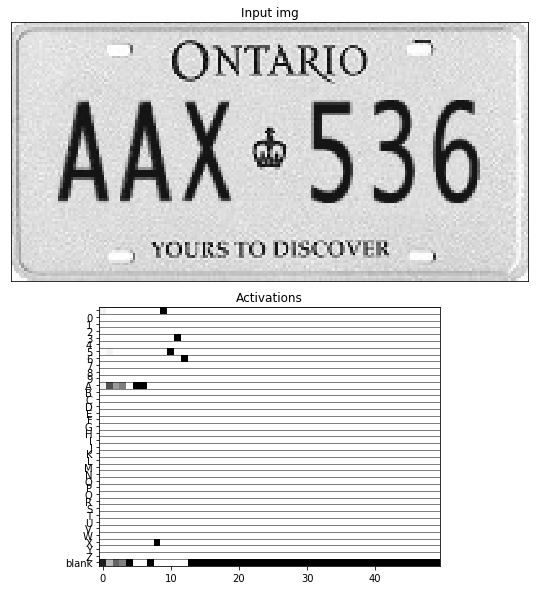

Predicted: ABT 077
True: ABT 077


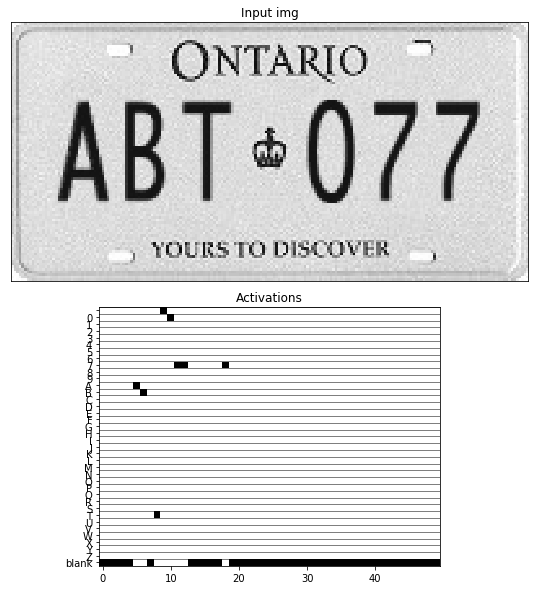

Predicted: ABY 207
True: ABY 207


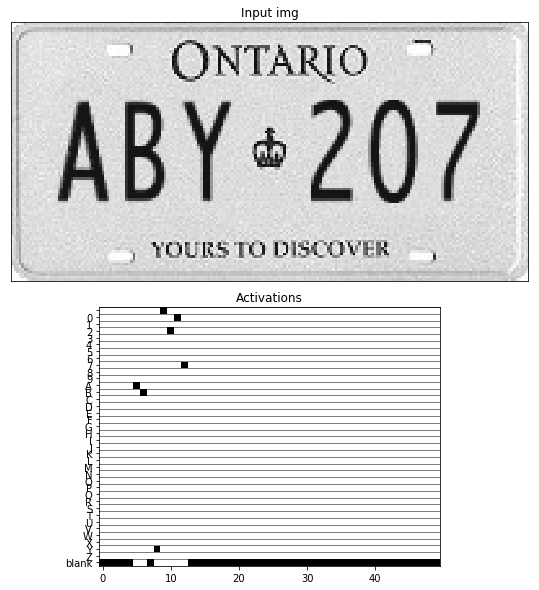

Predicted: ACB 817
True: ACB 817


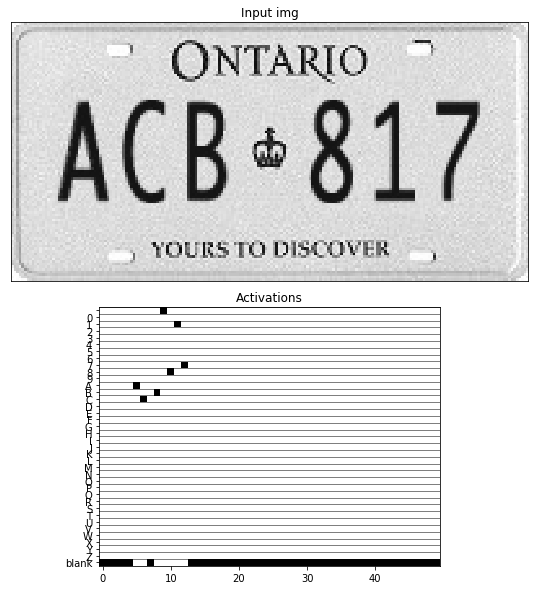

Predicted: ACK 178
True: ACK 178


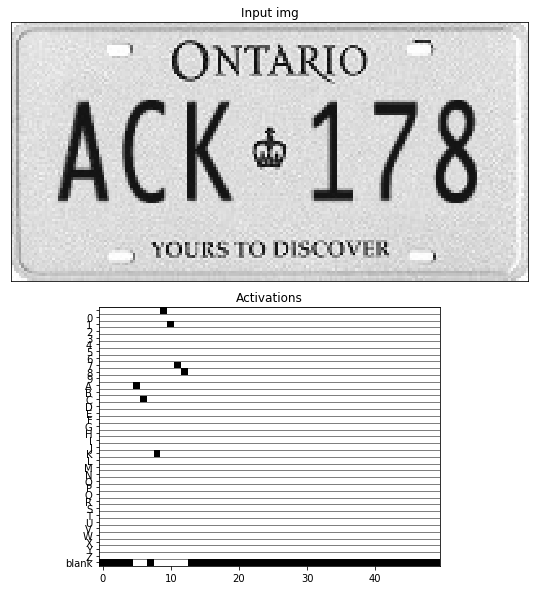

Predicted: ACK 272
True: ACK 272


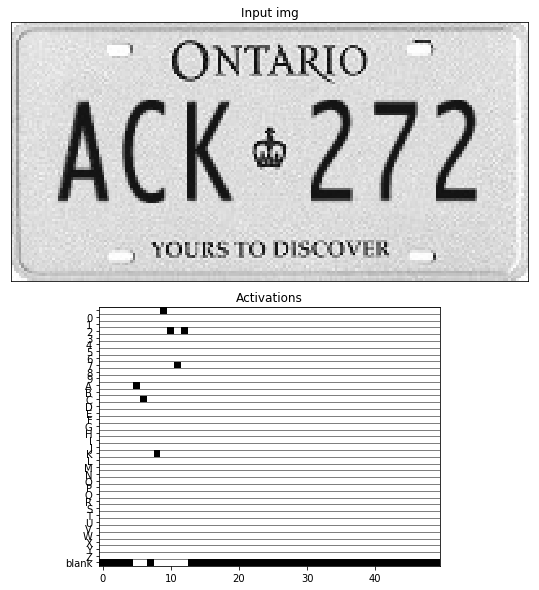

Predicted: ACM 656
True: ACM 656


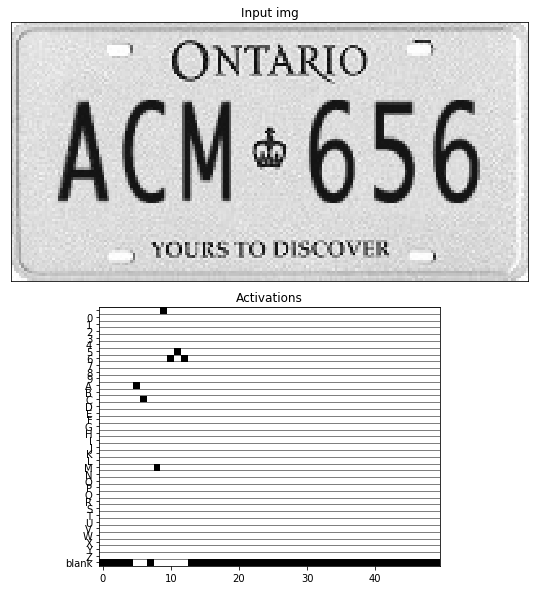

In [92]:
project_test = ImageDataGenerator('./plates/test', 200, 100, 7, 4)
project_test.build_data()

net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

for inp_value, _ in project_test.next_batch():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        texts.append(text)
    
    for i in range(bs):
        fig = plt.figure(figsize=(10, 10))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Predicted: %s\nTrue: %s' % (pred_texts[i], texts[i]))
        img = X_data[i][:, :, 0].T
        ax1.set_title('Input img')
        ax1.imshow(img, cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Activations')
        ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(letters) + 1)))
        ax2.set_yticklabels(letters + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(letters) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        #ax.axvline(x, linestyle='--', color='k')
        plt.show()
    break

In [73]:
len(project.samples)


15245

In [74]:
len(project.texts)

15245

In [75]:
project.samples[0][1]

'AAA 257.jpg'

In [76]:
project.samples[1]

['./plates/train', 'AAD 602.jpg']

In [77]:
temp = plt.imread(project.samples[0][0] + '/' + project.samples[0][1])

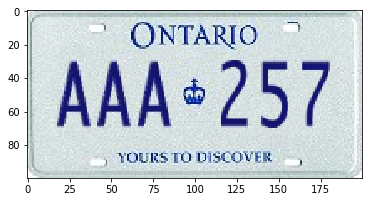

In [78]:
plt.imshow(temp)

In [79]:
import pandas as pd 

# Calling DataFrame constructor 
df = pd.DataFrame() 
  
print(df) 

Empty DataFrame
Columns: []
Index: []


In [80]:
print('Letters:', ' '.join(letters))

Letters:   0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z


# Testing begins here

In [91]:
project_test = ImageDataGenerator('./plates/test', 200, 100, 1900, 4)
project_test.build_data()
print('building')

net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

test_accuracy = 0
total = 0

print('length of project_test', len(project_test.texts))

for inp_value, _ in project_test.next_batch():
    total = total + 1
    bs = inp_value['the_input'].shape[0]
    #print('bs ', bs)
    X_data = inp_value['the_input']
    #print('X_data: ', X_data)
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch(net_out_value)
    print('pred_texts: ', pred_texts)
    labels = inp_value['the_labels']
    texts = []
     
    
    
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        texts.append(text)
    
    
    for i in range(bs): 
        print('Predicted: %s\nTrue: %s' % (pred_texts[i], texts[i]))
        
        if (pred_texts[i] == texts[i]):
            test_accuracy = test_accuracy + 1
            
            #print(i)
    break;
    
#print('Predicted ', pred_texts)
#print('True ', texts)

total = len(pred_texts)
print('test accuracy is ', test_accuracy/total)
print('total is ', total)


#for (i = 0 to len(pred_texts)):
    #if (pred_texts[i] == texts[i]):
        #print(pred_texts[i], texts[i]) #test_accuracy = test_accuracy + 1

#[i for i, j in zip(pred_texts, texts) if i == j]

#print ([i for i, j in zip(pred_texts, texts) if i == j])

#print(i)

#set(pred_texts).intersection(texts)



#test_accuracy = test_accuracy/total
#print('total is ', total)
#print('test_accuracy is ', test_accuracy)

AAO 810
AAX 536
ABT 077
ABY 207
ACB 817
ACK 178
ACK 272
ACM 656
ACN 407
ACN 715
ACX 858
ADD 086
ADO 535
ADT 418
AEE 161
AEJ 853
AEL 747
AFN 867
AFO 978
AGE 934
AGQ 108
AGQ 920
AHJ 650
AHL 804
AHX 144
AIA 537
AIO 171
AIW 421
AJD 074
AJE 636
AJK 852
AJY 482
AKZ 007
ALE 600
ALP 628
ALQ 685
ALZ 628
AMJ 620
AMK 124
ANF 777
ANK 848
ANT 744
AOD 883
AOE 675
AOS 634
APJ 637
AQK 736
AQO 649
AQT 181
ARJ 992
ARL 004
ARM 451
ARN 236
ASI 246
ASJ 949
ASO 686
ASU 204
ATB 533
ATE 540
ATN 480
ATO 918
AUH 289
AVG 567
AVM 161
AVM 998
AVQ 320
AWH 885
AWP 817
AXA 845
AXD 046
AYM 792
AYO 459
AYQ 355
AZA 133
AZN 813
AZO 357
AZR 214
BAB 310
BAD 823
BAV 191
BAZ 974
BBE 336
BBJ 650
BBR 754
BCH 572
BCR 292
BCT 999
BCX 590
BDM 446
BDM 938
BDO 863
BDY 621
BEH 021
BEM 811
BFA 191
BFD 563
BFG 264
BFP 199
BFS 694
BFX 645
BGZ 243
BHQ 755
BIB 711
BJA 094
BJM 360
BJQ 220
BJT 719
BKC 799
BKZ 171
BLQ 289
BLU 995
BMV 320
BNO 222
BNQ 245
BNZ 253
BOD 507
BOD 732
BOT 638
BPA 553
BPC 001
BPD 043
BPH 349
BQG 433
BQH 248
BQO 571


UMY 370
UMZ 674
UNN 363
UNT 436
UNT 987
UNX 528
UOI 678
UOJ 516
UOR 042
UPJ 422
UPN 187
UPZ 081
UQO 448
URH 179
USC 251
USQ 720
UTO 942
UTS 624
UTV 562
UTY 553
UUL 162
UUO 295
UUX 026
UVB 812
UVH 541
UVN 535
UVY 019
UWF 910
UWZ 727
UXM 709
UXO 597
UXQ 254
UYB 713
UYM 862
UYU 058
UZE 329
UZE 614
UZF 833
UZP 633
VAB 600
VAD 088
VAJ 095
VAP 613
VAQ 807
VAT 671
VAX 275
VBF 751
VBK 924
VBR 829
VCV 724
VDN 775
VEO 168
VFO 682
VFW 866
VGF 430
VGK 104
VGV 921
VHF 955
VHU 379
VIA 678
VIP 684
VIU 067
VJH 237
VJP 759
VJT 971
VKC 582
VKL 292
VKP 140
VKS 213
VKW 801
VLP 086
VME 044
VMI 788
VMM 407
VMO 468
VMP 771
VMW 950
VNG 890
VOB 710
VOG 270
VOM 284
VPS 875
VPU 485
VQD 943
VQW 064
VRC 248
VRM 634
VSF 683
VSI 796
VSL 321
VSN 815
VSQ 175
VST 669
VSZ 040
VTL 024
VUN 789
VUW 777
VVB 555
VVB 852
VVH 197
VVI 976
VVK 287
VWF 407
VWO 484
VYA 098
VYI 527
VZA 253
VZB 846
VZH 891
VZK 139
VZQ 021
VZR 040
VZT 740
WAQ 847
WAX 302
WBF 316
WCC 956
WCE 820
WCZ 114
WDV 446
WEE 207
WEN 100
WFD 558
WFI 166
WFQ 281


Predicted: AIA 537
True: AIA 537
Predicted: AIO 171
True: AIO 171
Predicted: AIW 421
True: AIW 421
Predicted: AJD 074
True: AJD 074
Predicted: AJE 636
True: AJE 636
Predicted: AJK 852
True: AJK 852
Predicted: AJY 482
True: AJY 482
Predicted: AKZ 007
True: AKZ 007
Predicted: ALE 600
True: ALE 600
Predicted: ALP 628
True: ALP 628
Predicted: ALQ 685
True: ALQ 685
Predicted: ALZ 628
True: ALZ 628
Predicted: AMJ 620
True: AMJ 620
Predicted: AMK 124
True: AMK 124
Predicted: ANF 777
True: ANF 777
Predicted: ANK 848
True: ANK 848
Predicted: ANT 744
True: ANT 744
Predicted: AOD 883
True: AOD 883
Predicted: AOE 675
True: AOE 675
Predicted: AOS 634
True: AOS 634
Predicted: APJ 637
True: APJ 637
Predicted: AQK 736
True: AQK 736
Predicted: AQO 649
True: AQO 649
Predicted: AQT 181
True: AQT 181
Predicted: ARJ 992
True: ARJ 992
Predicted: ARL 004
True: ARL 004
Predicted: ARM 451
True: ARM 451
Predicted: ARN 236
True: ARN 236
Predicted: ASI 246
True: ASI 246
Predicted: ASJ 949
True: ASJ 949
Predicted:

True: URH 179
Predicted: USC 251
True: USC 251
Predicted: USQ 720
True: USQ 720
Predicted: UTO 942
True: UTO 942
Predicted: UTS 624
True: UTS 624
Predicted: UTV 562
True: UTV 562
Predicted: UTY 553
True: UTY 553
Predicted: UUL 162
True: UUL 162
Predicted: UUO 295
True: UUO 295
Predicted: UUX 026
True: UUX 026
Predicted: UVB 812
True: UVB 812
Predicted: UVH 541
True: UVH 541
Predicted: UVN 535
True: UVN 535
Predicted: UVY 019
True: UVY 019
Predicted: UWF 910
True: UWF 910
Predicted: UWZ 727
True: UWZ 727
Predicted: UXM 709
True: UXM 709
Predicted: UXO 597
True: UXO 597
Predicted: UXQ 254
True: UXQ 254
Predicted: UYB 713
True: UYB 713
Predicted: UYM 862
True: UYM 862
Predicted: UYU 058
True: UYU 058
Predicted: UZE 329
True: UZE 329
Predicted: UZE 614
True: UZE 614
Predicted: UZF 833
True: UZF 833
Predicted: UZP 633
True: UZP 633
Predicted: VAB 600
True: VAB 600
Predicted: VAD 088
True: VAD 088
Predicted: VAJ 095
True: VAJ 095
Predicted: VAP 613
True: VAP 613
Predicted: VAQ 807
True: VAQ 

In [82]:
print(len(project.texts))

15245


In [83]:
print(project.texts[0])

AAA 257


In [84]:
print(letters)

[' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [85]:
print(project.texts[0])

AAA 257


# Data Visualization

In [86]:
test = list()

for _ in letters:
    count = 0
    for x in project.texts:
        found = x.find(_)
        if (found != -1):
            count = count + 1
    #print(count)
    #pandas - add 
    test.append(count)

df = pd.DataFrame(list(zip(letters, test)), 
              columns =['Character', 'count']) 
#remove the row for ' ' character
df = df.drop(0)
df
dn = df[0:10]
dn


,Character,count
1,0,4032
2,1,4169
3,2,4110
4,3,4209
5,4,4124
6,5,4191
7,6,4060
8,7,3972
9,8,4282
10,9,4101


In [87]:
dn.describe()

,count
count,10.000000
mean,4125.000000
std,91.336983
min,3972.000000
25%,4070.250000
50%,4117.000000
75%,4185.500000
max,4282.000000


In [88]:
da = df[10:36]
da


,Character,count
11,A,1701
12,B,1633
13,C,1705
14,D,1705
15,E,1722
16,F,1613
17,G,1706
18,H,1709
19,I,1709
20,J,1767


In [89]:
da.describe()

,count
count,26.000000
mean,1693.730769
std,38.772730
min,1613.000000
25%,1669.750000
50%,1702.000000
75%,1709.000000
max,1767.000000


Text(0,0.5,'# of Occurrences')

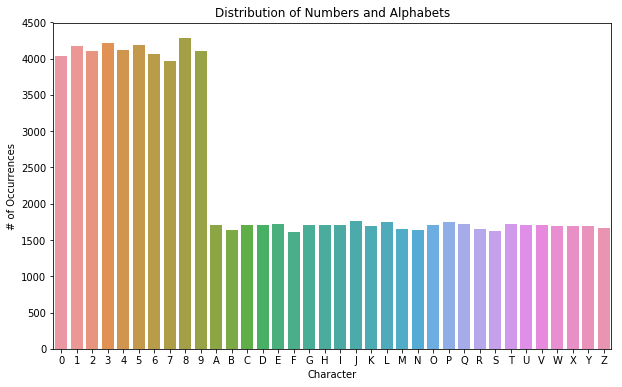

In [90]:
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set the width and height of the figure
plt.figure(figsize=(10,6))

# Add title
plt.title("Distribution of Numbers and Alphabets")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=df['Character'], y=df['count'])

# Add label for vertical axis
plt.ylabel("# of Occurrences")

